In [1]:
from time import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import warnings
warnings.simplefilter('ignore')

/home/ipynb/jupyter_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [30]:
df = pd.read_excel('data/Protva_3.xlsx')
test_size = 945
xcols = [col for col in df.columns[1:] if '(t+' not in col]
print(xcols)
ycols = 'Q(t+1)SZ'

X = df.loc[:,xcols]
y = df.loc[:,ycols]
print(X.shape, y.shape)
# print(X)
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

X_maxabs_scaled = X_scaled[test_size:]
X_test_maxabs_scaled = X_scaled[:test_size]

y_train = y[test_size:].reset_index(drop=True)
y_test = y[:test_size].reset_index(drop=True)

print(X_maxabs_scaled.shape, y_train.shape)
print(X_test_maxabs_scaled.shape, y_test.shape)

['QtSZ', 'Q(t-1)SZ', 'Q(t-2)SZ', 'Q(t-3)SZ', 'Q(t-4)SZ', 'Q(t-5)SZ', 'Q(t-6)SZ', 'Q(t-7)SZ', 'Δqmax2', 'Δqmax3', 'Δqmax4', 'Δqmax5', 'Δqmax6', 'Δqmax7', '27509(t)', '27509(t-1)', '27509(t-2)', '27509(t-3)', '27509(t-4)', '27509(t-5)', '27509(t-6)', '27509(t-7)', '27606(t)', '27606(t-1)', '27606(t-2)', '27606(t-3)', '27606(t-4)', '27606(t-5)', '27606(t-6)', '27606(t-7)', '27611(t)', '27611(t-1)', '27611(t-2)', '27611(t-3)', '27611(t-4)', '27611(t-5)', '27611(t-6)', '27611(t-7)', 'P(t)avg', 'P(t-1)avg', 'P(t-2)avg', 'P(t-3)avg', 'P(t-4)avg', 'P(t-5)avg', 'P(t-6)avg', 'P(t-7)avg', 'sum2', 'sum3', 'sum4', 'sum5', 'sum6', 'sum7', 'Iw', 'T>0', 'T>2', 'T>5', 'Evap']
(4726, 57) (4726,)
(3781, 57) (3781,)
(945, 57) (945,)


In [31]:
cv_split_method = KFold(n_splits=10)

cv_scorings = {
   'MSE': make_scorer(mean_squared_error),
    'NSE': make_scorer(r2_score),
    'default': make_scorer(r2_score),
}

param_grid = \
    {
    "hidden_layer_sizes": [(10,), (50,), (50, 50,)], 
    "activation": ["logistic"], 
    "solver": ["sgd", "adam"], 
    "alpha": [0.0005]
}

In [32]:
ann = MLPRegressor(max_iter=5000, warm_start=False, random_state=123, verbose=False)
start = time()
grid_search_ann = GridSearchCV(ann,
                                    param_grid=param_grid,
                                    cv=cv_split_method,
                                    scoring=cv_scorings,
                                    n_jobs=-1, 
                                    refit='NSE',
                                    verbose=True)
grid_search_ann.fit(X_maxabs_scaled, y_train)
print("GridSearchCV took %.2f seconds." % (time() - start))
# сохраняем лучшую модель из поиска
trained_ann = grid_search_ann.best_estimator_
filename = 'results/MLP_%s.pkl' % ycols
print(filename)
pickle.dump(trained_ann, open(filename, 'wb'))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.4min finished


GridSearchCV took 1645.06 seconds.
results/MLP_protva_all_year_Q(t+7)SZ.pkl


In [19]:
print(grid_search_ann.best_estimator_)
print(grid_search_ann.best_score_) 
print(grid_search_ann.cv_results_['mean_test_RMSE'][grid_search_ann.best_index_])

MLPRegressor(activation='logistic', alpha=0.0005, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=5000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=123, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
0.7249730558544074
-16.401514329503037


Train results for Q(t+3)SZ
0.849
12.646
Test results for Q(t+3)SZ
0.832
15.753


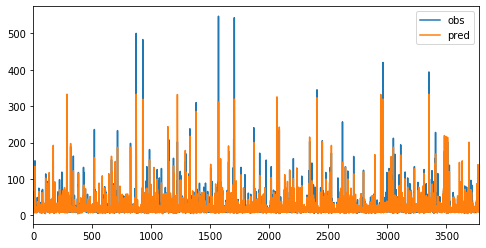

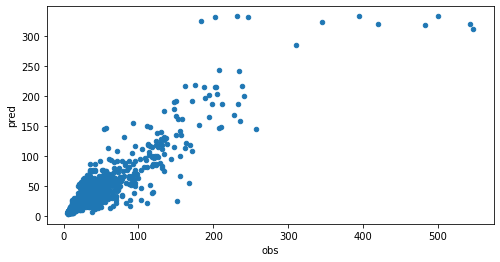

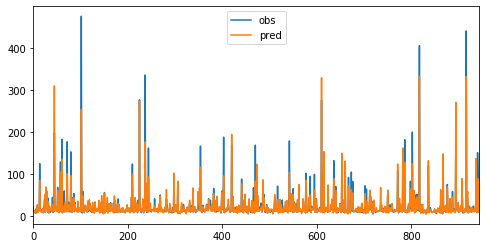

In [20]:
train_pred = grid_search_ann.predict(X_maxabs_scaled) 
test_pred = grid_search_ann.predict(X_test_maxabs_scaled)
# print(train_pred.shape, y_train.shape)
# print(test_pred.shape, y_test.shape)
train_df = pd.DataFrame({'obs': y_train, 'pred': train_pred})
test_df = pd.DataFrame({'obs': y_test, 'pred': test_pred})
train_df.to_excel('results/MLP_' + ycols + '.xlsx')
print("Train results for " + ycols)
print(round(NSE(train_df.obs, train_df.pred), 3))
print(round(RMSE(train_df.obs, train_df.pred), 3))
train_df.plot(kind='line', figsize=(8,4))
train_df.plot(x='obs', y='pred', kind='scatter', figsize=(8,4))
print("Test results for " + ycols)
print(round(NSE(test_df.obs, test_df.pred), 3))
print(round(RMSE(test_df.obs, test_df.pred), 3))
test_df.plot(kind='line', figsize=(8,4))

In [ ]:
test_pred_chrono = grid_search_ann.predict(X_chrono_test)
test_df_chrono = pd.DataFrame({'obs': y_chrono_test, 'pred': test_pred_chrono})
test_df.to_excel('results/MLP_' + ycols + '.xlsx')
print("Test results for " + ycols)
print(round(NSE(test_df_chrono.obs, test_df_chrono.pred), 3))
print(round(RMSE(test_df_chrono.obs, test_df_chrono.pred), 3))
test_df_chrono.plot(kind='line', figsize=(8,4))